In [95]:
from scipy.integrate import ode
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

MM = np.array((0,0,.2,.2,.2,.2,.2,.2,.4,.4,1.3,1.3,3.6,3.6,8,8))  ## mortality per 100

In [96]:
# Model Parameters (from adhikari's code)
n = 16 # Number of age divisions
my_data = np.genfromtxt('data/age_structures/India-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]
N_arr = aM+aF
N_arr = N_arr[0:n] # Population of each division
N = np.sum(N_arr) # total population

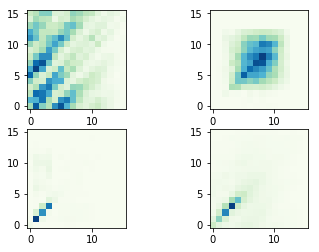

In [97]:
# contact matrices (from adhikari's code)
my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_home_1.xlsx', sheet_name='India',index_col=None)
CH = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_work_1.xlsx', sheet_name='India',index_col=None)
CW = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_school_1.xlsx', sheet_name='India',index_col=None)
CS = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_other_locations_1.xlsx', sheet_name='India',index_col=None)
CO = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_all_locations_1.xlsx', sheet_name='India',index_col=None)
CA = np.array(my_data)

C_a = CH + CW + CS + CO
C_sub = CW + CS + CO

plt.subplot(221)
plt.imshow(CH, cmap = 'GnBu', origin = 'lower')
plt.subplot(222)
plt.imshow(CW, cmap = 'GnBu', origin = 'lower')
plt.subplot(223)
plt.imshow(CS, cmap = 'GnBu', origin = 'lower')
plt.subplot(224)
plt.imshow(CO, cmap = 'GnBu', origin = 'lower')

In [98]:
#epidemic parameters
alpha_arr = 0.*np.ones(n) #fraction of asymptomatic individuals
gamma = 1./7*np.ones(n) #recover rate
beta = 0.01566 #Rate of contact
f = 1 # Distancing factor

In [106]:
def lockdown(t, t_on, t_off, t_w):
    return 0.5*np.sum(np.tanh((t - t_on)/t_w) - np.tanh((t - t_off)/t_w))

def func(t, y, gamma, beta, alpha_arr, C_a, f, C_sub, N_arr, n, t_on, t_off, t_w):
    S = y[:n]
    I_a = y[n:2*n]
    I_s = y[2*n:3*n]
    C_temp = C_a - C_sub*lockdown(t, t_on, t_off, t_w)
    lam = beta*(np.dot(C_temp, I_a/N_arr) + f*np.dot(C_temp, I_s/N_arr))
    dSdt = -lam*S
    dIadt = alpha_arr*lam*S - gamma*I_a
    dIsdt = (1-alpha_arr)*lam*S - gamma*I_s
    return np.concatenate((dSdt, dIadt, dIsdt))

In [111]:
Days = 98
delta_t = 1
t_arr = np.arange(0, Days, delta_t)

# initial conditions from adhikari's code 
Is_0 = np.zeros((n));  Is_0[4:11]=4;  Is_0[1:4]=1
Ia_0 = np.zeros((n))
R_0  = np.zeros((n))
S_0  = N_arr - (Ia_0 + Is_0 + R_0)

y_init = np.concatenate((S_0, Ia_0, Is_0))

#Lockdown Policy
t_on = np.array([21., 47., 80.])
t_off = np.array([42, 75, 98])
t_w = 0.01

solver = ode(func).set_integrator(name = 'lsoda', atol = 0.00001, rtol = 0.00001, nsteps = 100000)
solver.set_initial_value(y_init, 0).set_f_params(gamma, beta, alpha_arr, C_a, f, C_sub, N_arr, n, t_on, t_off, t_w)

arr = []
for i in range(len(t_arr)):
    solver.integrate(solver.t + delta_t)
    arr.append(solver.y)
    
arr = np.array(arr)



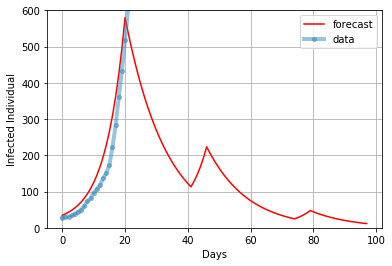

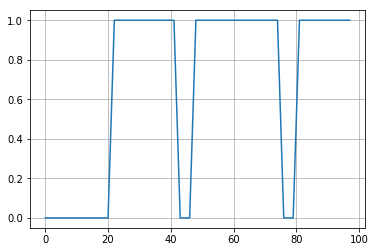

In [112]:
# plt.plot(t_arr, np.sum(arr[:, 0:n], axis = 1), label = 'S')
# plt.plot(t_arr, np.sum(arr[:, n:2*n], axis = 1), label = 'I_a')    
plt.plot(t_arr, np.sum(arr[:, 2*n:3*n], axis = 1), label = 'forecast', color = 'r')
# plt.plot(t_arr, N - np.sum(arr[:, 0:n], axis = 1) - np.sum(arr[:, n:2*n], axis = 1) - np.sum(arr[:, 2*n:3*n], axis = 1), label = 'R')


my_data = np.genfromtxt('data/covid-cases/india.txt', delimiter='', skip_header=6)
day, cases = my_data[:,0], my_data[:,2]
plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=4, label='data', alpha=0.5)


plt.grid(1)
plt.legend(loc = 'best')
plt.ylabel("Infected Individual")
plt.xlabel("Days")
plt.ylim((0, 600))


plt.figure(2)
ans = []
for i in t_arr:
    ans.append(lockdown(i, t_on, t_off, t_w))
plt.plot(t_arr, ans)
plt.grid(1)

In [113]:
print "Number of Predicted Deaths:", np.sum((arr[0, 0:n] - arr[-1, 0:n])*0.01*MM )

Number of Predicted Deaths: 8.29418734472245
